In [1]:
import altair as alt
import cnvutils
import cptac
import IPython.display
import numpy as np
import os
import pandas as pd
import statsmodels

from cnvutils.filenames import (
    get_all_props_path,
    get_diffs_boxplot_path,
    get_has_event_path,
    get_proportions_perm_p_values_path,
    get_protein_ttest_boxplot_path,
    get_ttest_results_path,
)

from cnvutils.constants import (
    CHART_FORMAT,
    CHART_RENDER_METHOD,
    CHART_SCALE,
    SIG_CUTOFF,
)

from cnvutils.load_data import (
    get_cnv_counts,
    get_tables,
    get_ensembl_gene_locations,
    get_ncbi_gene_locations,
)

from cnvutils.chromosome_funcs import (
    select_genes_for_event,
)

In [2]:
def split_groups(df, split_cols, results, prefix):
    """Recursively split proportions into subgroups and run t-tests on subgroups."""
    
    if len(split_cols) == 0:
        return
    
    col = split_cols[0]
    for val in df[col].unique():
        
        group = df[df[col] == val]
        new_prefix = "_".join([prefix, val])
        group = group.assign(
            group=new_prefix
        )
        
        results.append(group)
        
        split_groups(
            df=group,
            split_cols=split_cols[1:],
            results=results,
            prefix=new_prefix,
        )

In [3]:
def make_diffs_boxplot(
    chromosome,
    proteomics_or_transcriptomics,
    source,
    level=None,
    data_dir=os.path.join(os.getcwd(), "..", "..", "data"),
):

    all_props = pd.read_csv(get_all_props_path(
        data_dir=data_dir,
        chromosome=chromosome,
    ), sep="\t")

    sig = all_props[
        (all_props["prop_name"] == "sig_prop") &
        (all_props["proteomics_or_transcriptomics"] == proteomics_or_transcriptomics) &
        (all_props["source"] == source)
    ].\
    dropna(how="any", axis=0).\
    reset_index(drop=True)

    sig = sig.\
    assign(diff=sig["not_has_prop"] - sig["has_prop"]).\
    drop(columns=[
        "not_has_prop",
        "has_prop",
        "proteomics_or_transcriptomics",
        "source",
        "level",
        "prop_name",
    ])

    res = [sig.assign(group="p_all")]
    split_groups(
        df=sig,
        split_cols=[
            "cis_or_trans",
            "gain_or_loss",
        ],
        results=res,
        prefix="p",
    )

    plt = pd.concat(res)

    p_path = get_proportions_perm_p_values_path(
        data_dir=data_dir,
        chromosome=chromosome,
    )

    p_vals = pd.read_csv(p_path, sep="\t")

    # Filter out just the p values we want
    p_vals = p_vals[p_vals["group"] == "sig_props"][["name", "p"]]
    p_vals = p_vals[p_vals["name"].str.contains(source)]

    # Benjamini-Hochberg FDR correction
    reject, adj_p, alphac_sidak, alphac_bonf = statsmodels.stats.multitest.multipletests(
        pvals=p_vals["p"],
        alpha=SIG_CUTOFF,
        method="fdr_bh",
    )

    p_vals = p_vals.assign(adj_p=adj_p)

    p_vals = p_vals[p_vals["name"].str.contains(proteomics_or_transcriptomics)]

    p_vals = p_vals.assign(
        name=p_vals["name"].str.replace(f"_{source}_{proteomics_or_transcriptomics}", "").replace({"p": "p_all"})
    ).drop(columns="p")

    plt = plt.merge(
        p_vals,
        how="inner",
        left_on="group",
        right_on="name",
    )

    plt = plt.assign(sig=(plt["adj_p"] <= SIG_CUTOFF).replace({True: "p <= 0.05", False: "p > 0.05"}))
    p_vals = p_vals.assign(sig=(p_vals["adj_p"] <= SIG_CUTOFF).replace({True: "p <= 0.05", False: "p > 0.05"}))

    bp = alt.Chart(plt).mark_boxplot(
        size=50,
        extent='min-max',
    ).encode(
        x=alt.X(
            "group",
            axis=alt.Axis(
                title=None,
                labelAngle=-30,
            )
        ),
        y=alt.Y(
            "diff",
            title="(No event prop affected) - (Has event prop affected)",
        ),
        color=alt.Color(
            "sig",
            title=None,
            scale=alt.Scale(
                domain=["p <= 0.05", "p > 0.05"],
                range=["#54a24b", "#4c78a8"]
            ),
        ),
    ).properties(
        width=500,
    )

    p_vals = p_vals.\
    assign(
        line=-np.log10(SIG_CUTOFF),
        neg_log_adj_p=-np.log10(p_vals["adj_p"]),
    )

    base = alt.Chart(p_vals)

    dots = base.mark_point(
        filled=True,
        opacity=1,
    ).encode(
        x=alt.X(
            "name",
            axis=alt.Axis(
                title=None,
                labels=False,
                ticks=False,
            ),
        ),
        y=alt.Y(
            "neg_log_adj_p",
            axis=alt.Axis(
                title="-log(p)",
                titlePadding=15,
            ),
        ),
        color=alt.Color(
            "sig",
        )
    )

    line = base.mark_rule(color="crimson").encode(
        y="line"
    )

    mhp = (dots + line).properties(
        width=500,
        height=100
    )

    xax = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
        opacity=0.2,
    ).encode(y='y')

    final = alt.vconcat(
        mhp,
        bp + xax,
        spacing=15,
    ).properties(
        title=["Significance and magnitude of difference in proportion",
              f"of tumor/normal affected vs. not affected {'proteins' if proteomics_or_transcriptomics == 'proteomics' else 'RNA'} between",
               "samples with and without chromosome 8 CNV events",],
    ).configure_axis(
        grid=False,
        domainWidth=1,
        domainColor="black",
    ).configure_title(
        fontSize=15,
        anchor="middle",
        orient="top",
        dy=-10,
    ).configure_view(
        strokeOpacity=0,
    )

    save_path = get_diffs_boxplot_path(
        data_dir=data_dir,
        source=source,
        level=level,
        chromosome=chromosome,
        chart_format=CHART_FORMAT,
    )

    final.save(save_path, method=CHART_RENDER_METHOD, scale_factor=CHART_SCALE)

    return save_path

In [4]:
path = make_diffs_boxplot(
    chromosome=8,
    proteomics_or_transcriptomics="proteomics",
    source="gistic",
    level="gene",
)

INFO:tornado.access:200 GET / (::1) 4.98ms
INFO:tornado.access:200 GET / (::1) 4.98ms
INFO:tornado.access:200 GET /vega.js (::1) 4.43ms
INFO:tornado.access:200 GET /vega.js (::1) 4.43ms
INFO:tornado.access:200 GET /vega-lite.js (::1) 7.46ms
INFO:tornado.access:200 GET /vega-lite.js (::1) 7.46ms
INFO:tornado.access:200 GET /vega-embed.js (::1) 9.98ms
INFO:tornado.access:200 GET /vega-embed.js (::1) 9.98ms


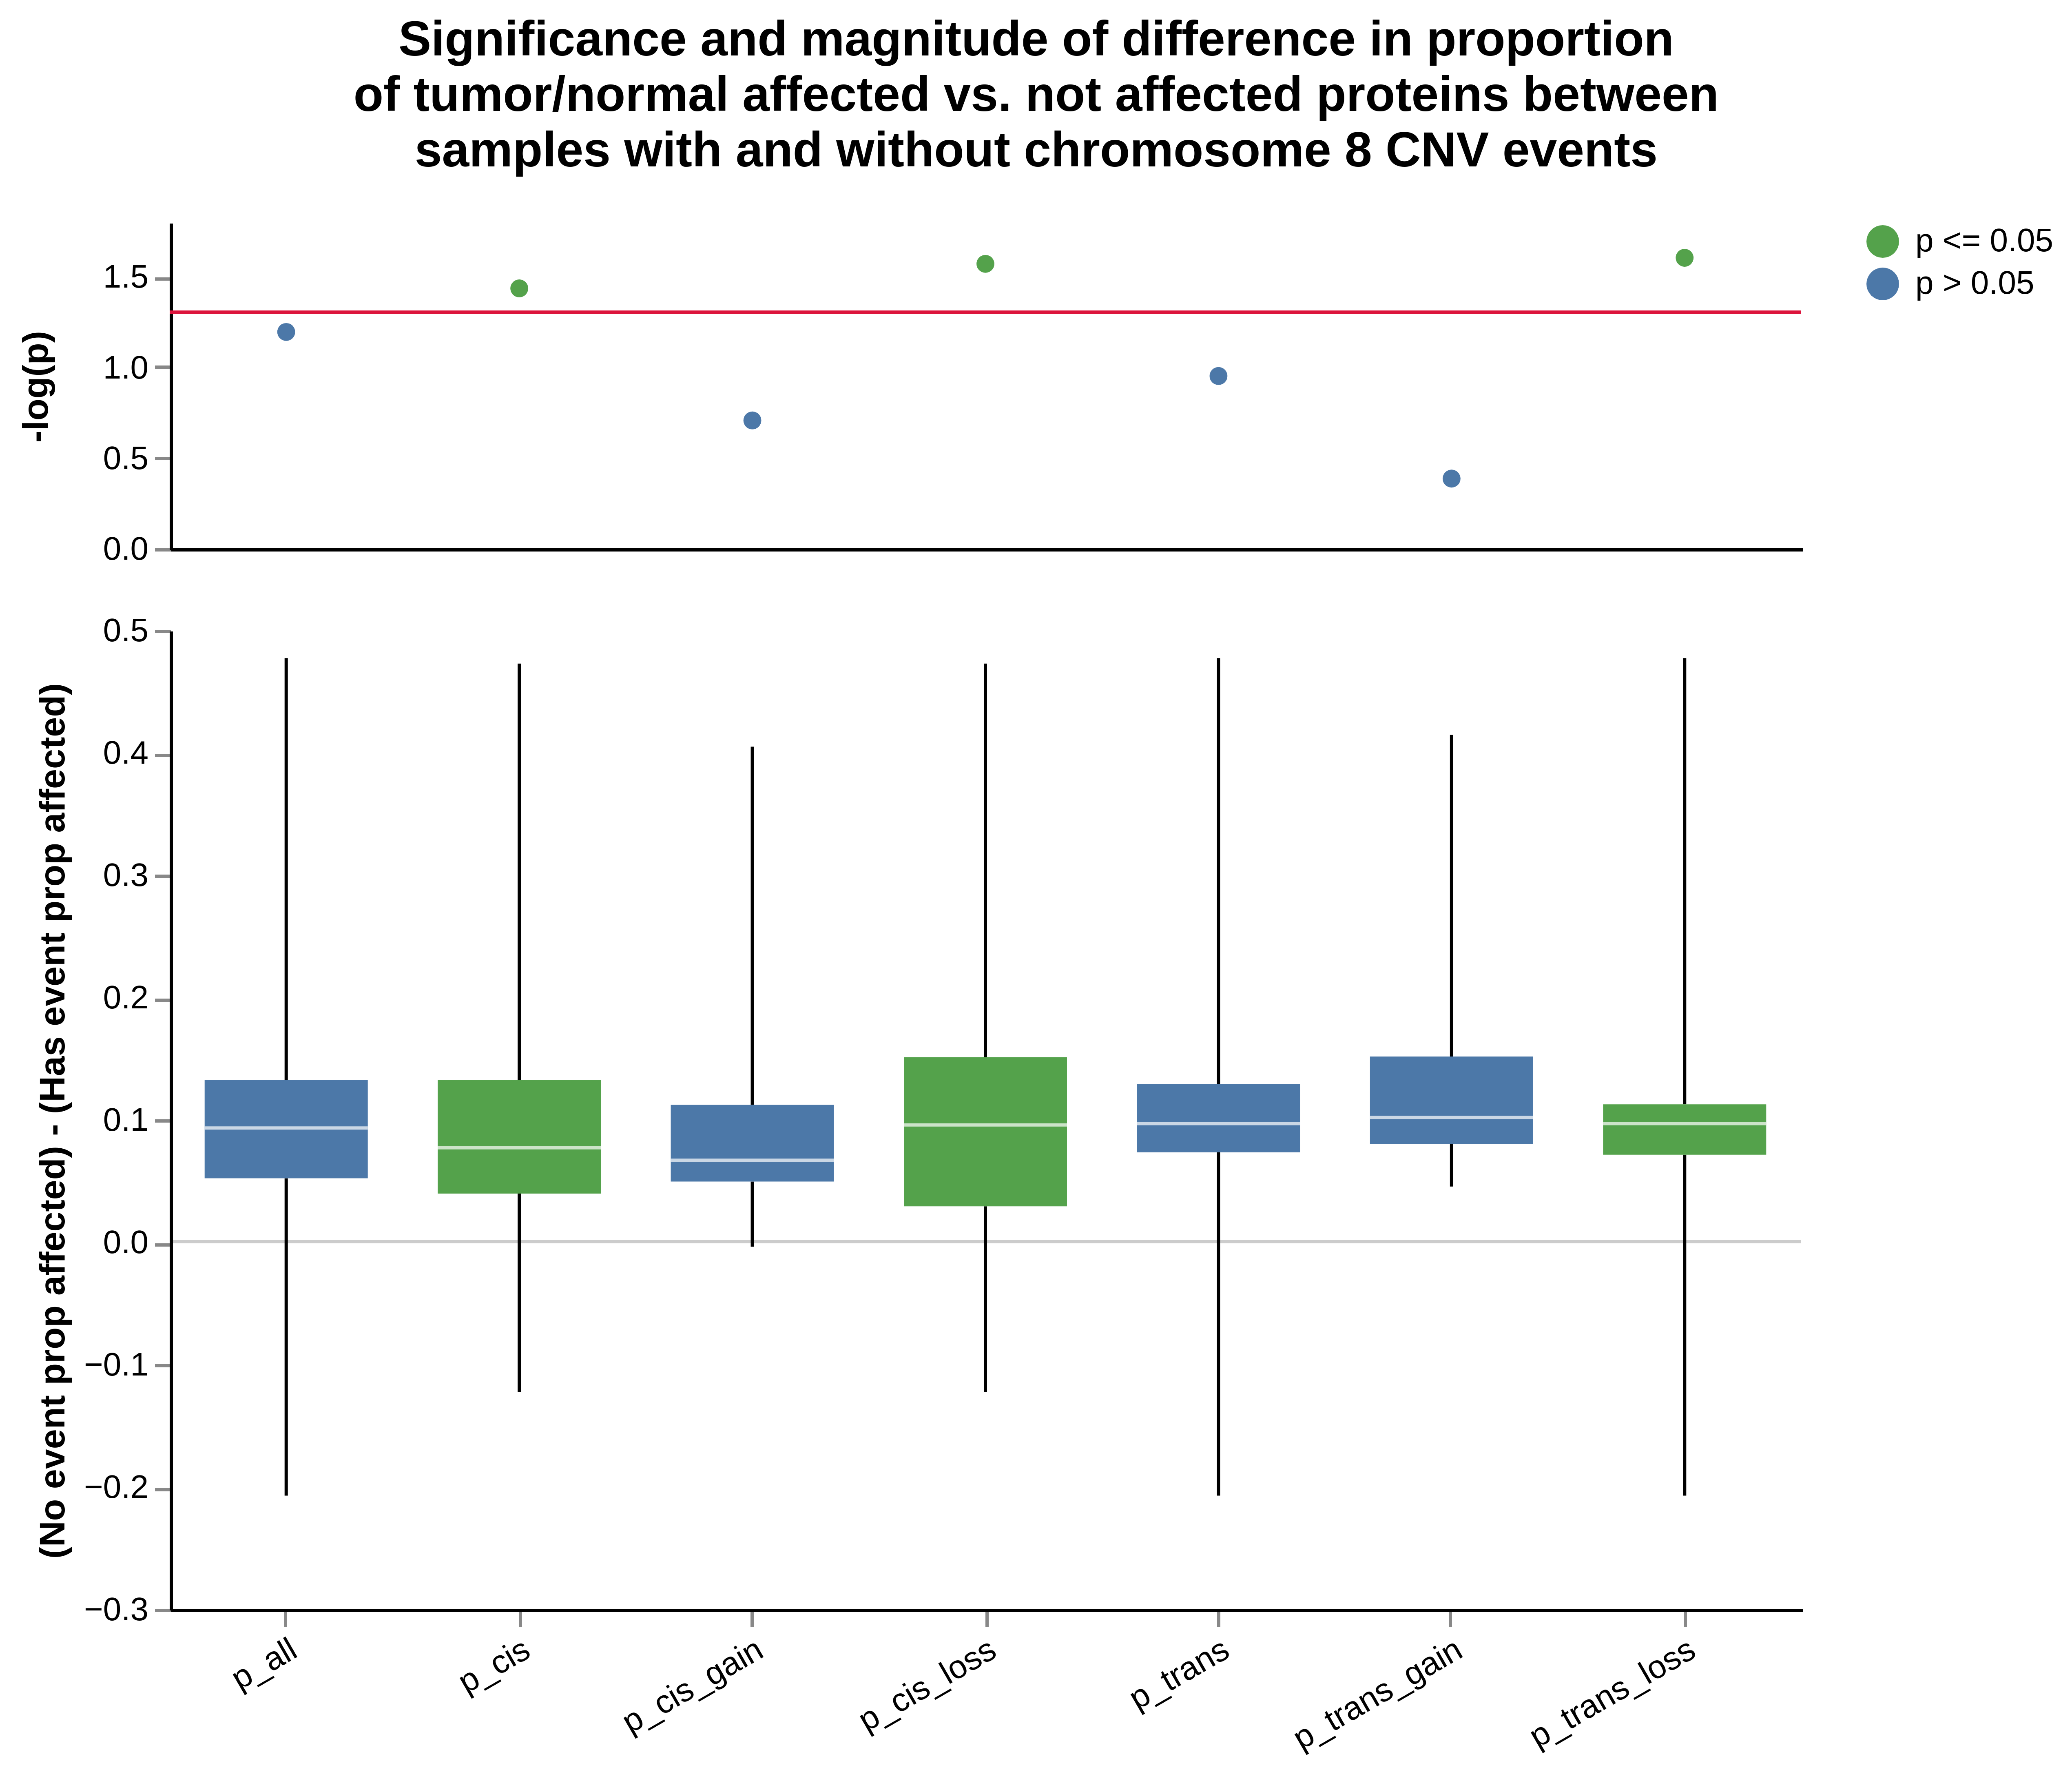

In [5]:
IPython.display.Image(path)